In [1]:
import sys, os
import swat as sw
from mayavi import mlab
import numpy as np
import matplotlib
from IPython.display import display
from matplotlib import image as mpimg
import matplotlib.pylab as plt
import pandas as pd
import struct

from importlib import reload
from tabulate import tabulate
pd.set_option('display.max_colwidth', -1)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
from itertools import cycle, islice
import matplotlib.font_manager as fm

from dlpy.network import *
from dlpy.utils import *
from dlpy.applications import *
from dlpy.model import *
from dlpy.images import *
from dlpy.layers import *

********************************************************************************
         to build the TVTK classes (7.0). This may cause problems.
         Please rebuild TVTK.
********************************************************************************



In [2]:
cashost='localhost'
casport=12125
s = swat.CAS(cashost, casport)
s.loadactionset('image')
s.loadactionset('biomedimage')
s.loadactionset('fedsql')
s.loadactionset('deepLearn')

NOTE: Added action set 'image'.
NOTE: Added action set 'biomedimage'.
NOTE: Added action set 'fedsql'.
NOTE: Added action set 'deepLearn'.


[actionset]

 'deepLearn'

+ Elapsed: 0.00338s, user: 0.000322s, sys: 0.00245s, mem: 0.252mb

In [3]:
demo_path = '<path to the root dir of images and annotations>'
caslib_name = 'demo'
demo_subdir = ''
s.addcaslib(name=caslib_name, path=demo_path, subdirectories=True, datasource='path')

In [5]:
slides_dir = '<relative path to slides images>'  # Slides
caslib_name = 'casuser'

def load_slides(cas_session, slides_table):
    """Load the slides."""
    casout = s.CASTable(slides_table, replace=True)
    s.image.loadimages(path=slides_dir, caslib=caslib_name, casout=casout, decode=True)
    fetched_slides = casout[['_resolution_', '_image_', '_path_']].to_frame()
    slide_binaries = fetched_slides['_image_']
    slide_resolutions = fetched_slides['_resolution_']
    slide_paths = fetched_slides['_path_']
    res = np.frombuffer (slide_resolutions[0], np.int64)
    slide_width = res[0]
    slide_height = res[1]
    return slide_binaries, slide_paths, slide_width, slide_height

slide_binaries, slide_paths, slide_width, slide_height = load_slides(s, 'slides')

bar_colors_sc = ['#007477','#a2d3d9']

def plot_volumes_with_ground_truth_sc(volumes, volumes_gt):

    stats = volumes.to_frame()
    stats._minimum_ = (stats._minimum_.astype(int))

    stats_gt = volumes_gt.to_frame()
    stats_gt._minimum_ = (stats_gt._minimum_.astype(int))+1

    joined = pd.concat([stats, stats_gt])
    joined['_content_'] = joined['_content_']/1000000
    qua = joined.pivot(index='_id_', columns='_minimum_', values='_content_')
    plot_bar_chart_with_ground_truth_sc(qua, r'Spinal Cord volume ($\mathregular{\times 10^6\ mm^3}$)')

def plot_bar_chart_with_ground_truth_sc(qua, ylabel):
    my_colors = list(islice(cycle(bar_colors_sc), None, len(qua)))
    my_edge_colors = bar_edge_colors
    ax = qua.plot(kind='bar', width=0.75, align='center', color=my_colors, edgecolor=bar_colors_sc)
    for i in range(len(qua.columns)):
        for j in range(len(qua)):
            ax.containers[i][j].set_edgecolor(bar_colors_sc[i])
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#2b3138')
    ax.grid(axis='y', color='#2b3138', linestyle=':', alpha=0.3, linewidth=2)
    legend = ax.legend(bbox_to_anchor=(1, 1), prop=ax_ticks_fp)
    legend.get_texts()[0].set_text('Model Predicted')
    legend.get_texts()[1].set_text('Ground Truth')

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_width, fig_height)
    plt.xlabel('Patient ID', fontproperties=ax_labels_fp)
    plt.text(0, 1.05, ylabel, fontproperties=ax_labels_fp, transform=ax.transAxes, ha='center', va='center')
    plt.xticks(fontproperties=ax_ticks_fp, rotation='horizontal')
    plt.yticks(fontproperties=ax_ticks_fp)
    plt.tight_layout()
    return ax

bar_edge_colors = ['#007477', '#C96400', '#758c20']
fig_width = 20
fig_height = 10

ax_labels_fp = fm.FontProperties(size=24)
ax_ticks_fp = fm.FontProperties(size=20)

def display_slice_3d(images, dims, ress, fmts, poss, oris, scas, perm, image_index, slice_index, rf, imin=-100, imax=400, additive=0):
    """Display an image slice in 3D."""
    image = get_image_array(images, dims, ress, fmts, image_index)
    geo_perm = np.zeros(3, dtype=np.int)
    for i in range(3):
        geo_perm[mapping(i)] = mapping(perm[i])
    image = np.transpose(image, perm)
    image = image[slice_index, :, :] + additive
    nr, nc = image.shape[:2]
    dimension = int(dims[image_index])
    pos = np.array(struct.unpack('=%sd' % dimension, poss[image_index]))
    sca = np.array(struct.unpack('=%sd' % dimension, scas[image_index][0:8 * dimension]))
    ori = np.array(struct.unpack('=%sd' % (dimension*dimension), oris[image_index][0:8 * dimension * dimension]))
    xx, yy = np.meshgrid(np.linspace(0, nc, nc), np.linspace(0, nr, nr))
    zz = np.zeros((nr, nc))
    lc = np.vstack((np.reshape(xx, (1, nc*nr)), np.reshape(yy, (1, nc*nr)), np.reshape(zz, (1, nc*nr))))
    ori = np.reshape(ori, (3, 3))
    ori = ori[:, geo_perm]
    sca = sca[geo_perm]
    pos = pos + slice_index * sca[2] * ori[:, 2]
    pos = np.reshape(pos, (3, 1))
    sca = np.diag(sca)
    gc = np.matmul(ori, np.matmul(sca, lc))
    gc = gc + np.matmul(pos, np.ones((1, nc*nr)))
    mlab.mesh(np.reshape(gc[0, :], (nr, nc)), np.reshape(gc[1, :], (nr, nc)), np.reshape(gc[2, :], (nr, nc)),
              scalars = image, colormap='gray', vmin=imin, vmax=imax)
    if (rf):
        for i in range(3):
            clr=((i == 0) * 1, (i == 1) * 1, (i == 2) * 1)
            mlab.quiver3d(pos[0], pos[1], pos[2], ori[0, i], ori[1, i], ori[2, i],
                          line_width=5, scale_factor=50*sca[i, i], color=clr, mode='arrow')
            
def get_image_array_from_row(image_binary, dimension, resolution, myformat, channel_count=1):
    """Get a 3D image from CAS table row."""
    num_cells = np.prod(resolution)
    if (myformat == '32S'):
        image_array = np.array(struct.unpack('=%si' % num_cells, image_binary[0:4 * num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '32F':
        image_array = np.array(struct.unpack('=%sf' % num_cells, image_binary[0:4 * num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '64F':
        image_array = np.array(struct.unpack('=%sd' % num_cells, image_binary[0:8 * num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '64U':
        image_array = np.array(struct.unpack('=%sQ' % num_cells, image_binary[0:8 * num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '16S':
        image_array = np.array(struct.unpack('=%sh' % num_cells, image_binary[0:2 * num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '16U':
        image_array = np.array(struct.unpack('=%sH' % num_cells, image_binary[0:2 * num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '8U' and channel_count==3:
        image_array = np.array(bytearray(image_binary[0:(num_cells*3)]))
        image_array = np.reshape(image_array, (resolution[0], resolution[1], 3))[:, :, 0:3]
        image_array = reverse(image_array, 2)
    elif myformat == '8S':
        image_array = np.array(struct.unpack('=%sb' % num_cells, image_binary[0:num_cells]))
        image_array = np.reshape(image_array, resolution)
    elif myformat == '8U':
        image_array = np.array(struct.unpack('=%sB' % num_cells, image_binary[0:num_cells]))
        image_array = np.reshape(image_array, resolution)
    else:
        image_array = np.array(bytearray(image_binary))
        image_array = np.reshape(image_array, (resolution[0], resolution[1], 3))
        image_array = reverse(image_array, 2)
    return image_array

def get_image_array(image_binaries, dimensions, resolutions, formats, n, channel_count=1):
    """Get a 3D image from CAS table."""
    dimension = int(dimensions[n])
    resolution = np.array(struct.unpack('=%sq' % dimension, resolutions[n][0:dimension * 8]))
    resolution = resolution[::-1]
    myformat = formats[n]
    num_cells = np.prod(resolution)
    return get_image_array_from_row(image_binaries[n], dimension, resolution, myformat, channel_count)

def mapping(val):
    """A simple mapping from int to int."""
    if (val == 0):
        return 2
    elif (val == 2):
        return 0
    else:
        return val

def remove_duplicates(array): 
    final_list = [] 
    for num in array: 
        if num not in final_list: 
            final_list.append(num) 
    return final_list

NOTE: Loaded 11 images from /u/coambr/SpinalCordSeg/SpinalCordSegmentationPipeline into Cloud Analytic Services table slides.


NOTE: Table SLIDES contains decompressed images.


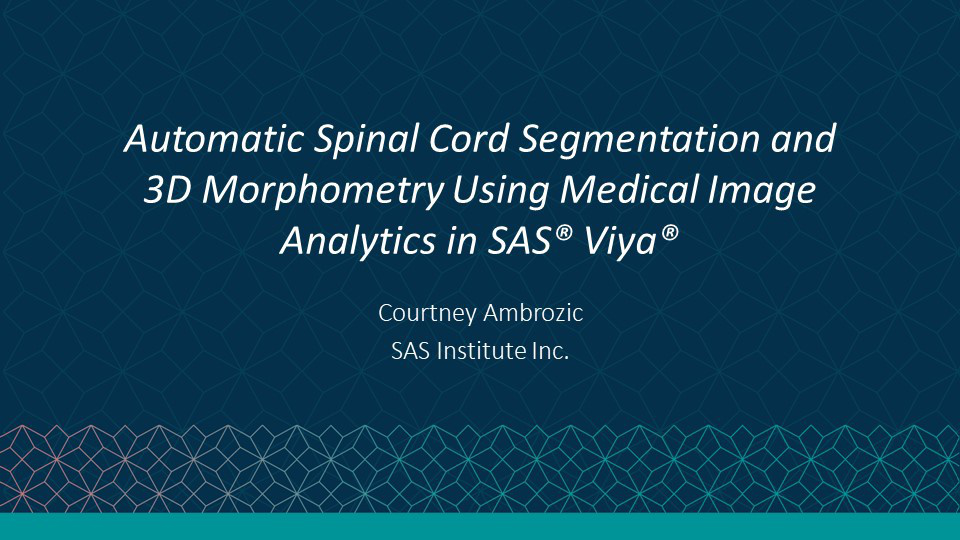

In [6]:
s.image.fetchImages(imageTable = 'slides').Images.Image[0]

NOTE: Table SLIDES contains decompressed images.


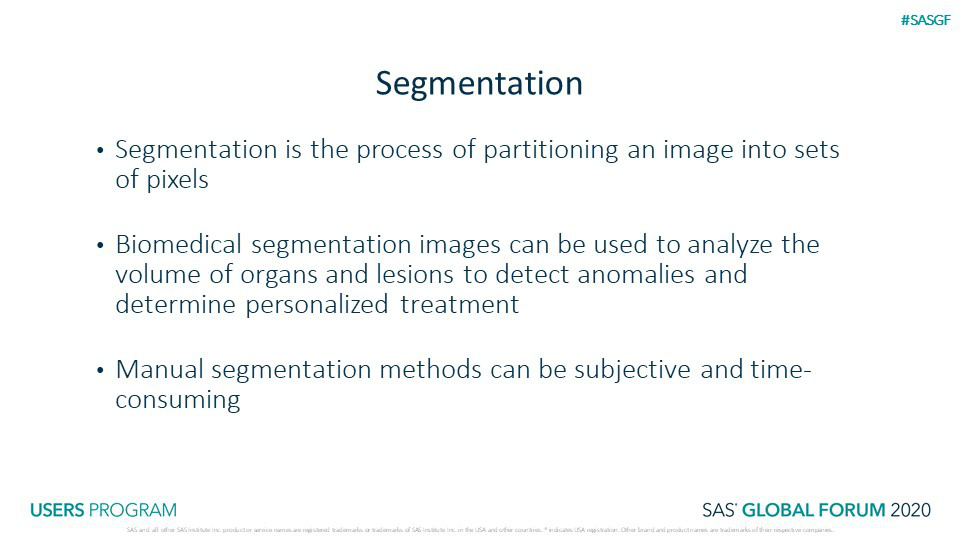

In [7]:
s.image.fetchImages(imageTable = 'slides').Images.Image[1]

NOTE: Table SLIDES contains decompressed images.


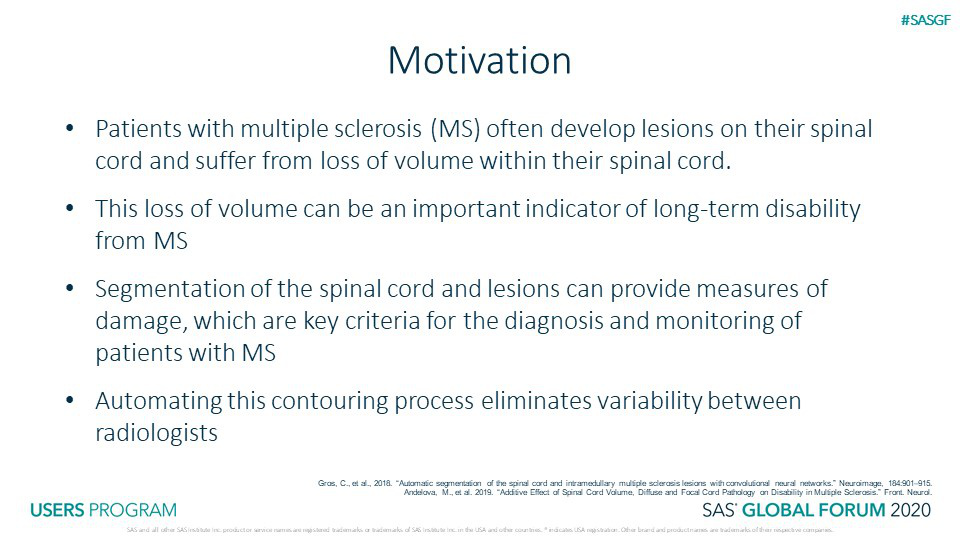

In [8]:
s.image.fetchImages(imageTable = 'slides').Images.Image[2]

NOTE: Table SLIDES contains decompressed images.


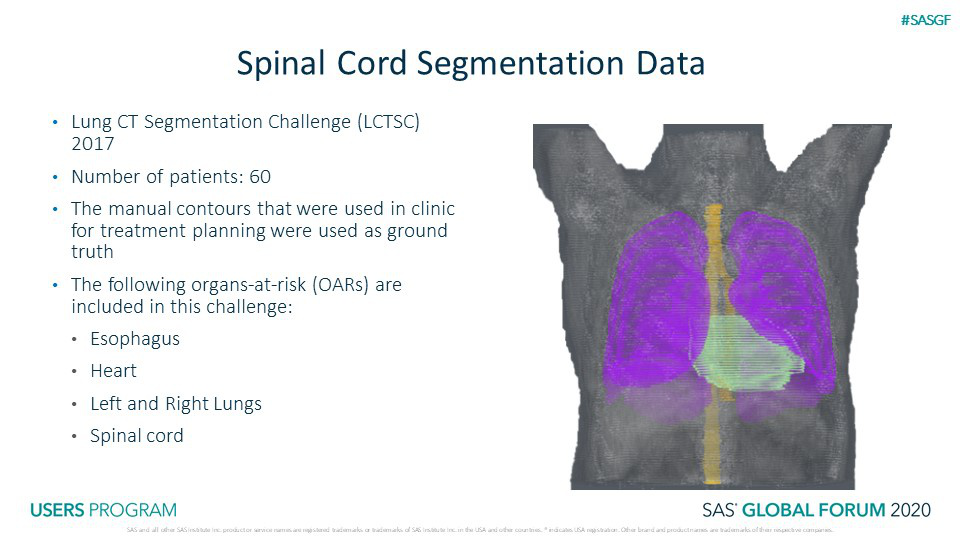

In [9]:
s.image.fetchImages(imageTable = 'slides').Images.Image[3]

Citation:

Yang, Jinzhong; Sharp, Greg; Veeraraghavan, Harini ; van Elmpt, Wouter ; Dekker, Andre; Lustberg, Tim; Gooding, Mark. (2017). Data from Lung CT Segmentation Challenge. The Cancer Imaging Archive. http://doi.org/10.7937/K9/TCIA.2017.3r3fvz08

Yang, J. , Veeraraghavan, H. , Armato, S. G., Farahani, K. , Kirby, J. S., Kalpathy‐Kramer, J. , van Elmpt, W. , Dekker, A. , Han, X. , Feng, X. , Aljabar, P. , Oliveira, B. , van der Heyden, B. , Zamdborg, L. , Lam, D. , Gooding, M. and Sharp, G. C. (2018), Autosegmentation for thoracic radiation treatment planning: A grand challenge at AAPM 2017. Med. Phys.. . doi:10.1002/mp.13141

Clark K, Vendt B, Smith K, Freymann J, Kirby J, Koppel P, Moore S, Phillips S, Maffitt D, Pringle M, Tarbox L, Prior F. The Cancer Imaging Archive (TCIA): Maintaining and Operating a Public Information Repository, Journal of Digital Imaging, Volume 26, Number 6, December, 2013, pp 1045-1057. (paper)

NOTE: Table SLIDES contains decompressed images.


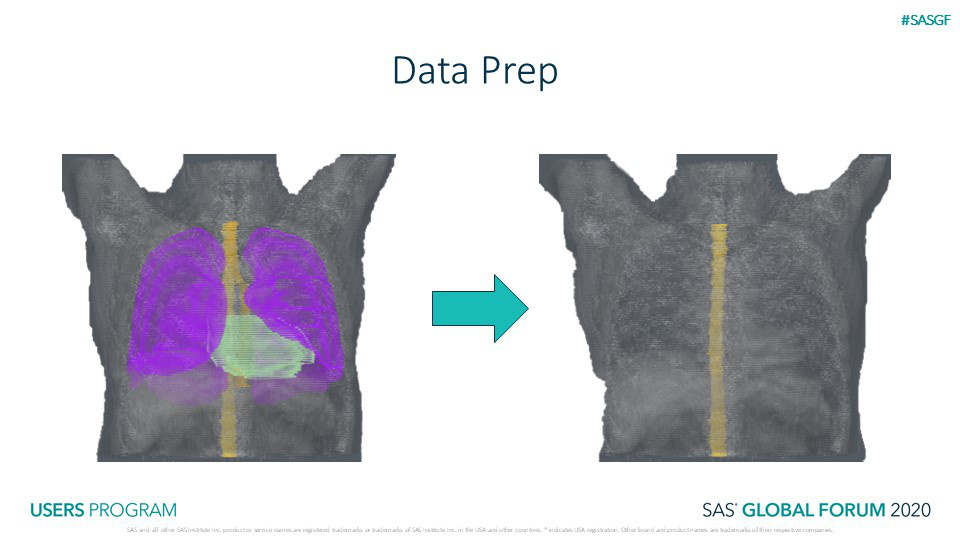

In [10]:
s.image.fetchImages(imageTable = 'slides').Images.Image[4]

### Load patient images

In [11]:
imsuid = 'SeriesInstanceUID'
impn = 'PatientName'
imad = 'AcquisitionDate'
impa = 'PatientAge'
impx = 'PatientSex'
allKeysIm = [imsuid, impn, imad, impa, impx]

image = s.CASTable('image', replace=True)
s.image.loadimages(
    path=demo_subdir,
    caslib='bigdisk',
    casout=image,
    addColumns=dict(
        general=['position', 'orientation', 'spacing', 'channeltype', 'width', 'height', 'depth'],
        dicomattributes=dict(keywords=allKeysIm)),
    series=dict(dicom=True),
    recurse=True,
    labellevels=1,
    decode=True
)

NOTE: Loaded 60 images from /bigdisk/lax/coambr/ahhati/LCTSC into Cloud Analytic Services table image.


[OutputCasTables]

             casLib   Name Label  Rows  Columns  \
 0  CASUSER(coambr)  image        60    21        
 
                                       casTable  
 0  CASTable('image', caslib='CASUSER(coambr)')  

+ Elapsed: 53.6s, user: 22.2s, sys: 18.9s, mem: 2.64e+03mb

### Load DICOM-RT files

In [12]:
patient='PatientID'
image_check='Modality'
rtcsq = 'ROIContourSequence'
rtsuid = 'ReferencedFrameOfReferenceSequence{1}RTReferencedStudySequence{1}RTReferencedSeriesSequence{1}SeriesInstanceUID' 
rtsdesc = 'SeriesDescription'
allKeysRt = [rtsuid, rtcsq, rtsdesc,patient,image_check]
rtdata_points=s.CASTable("rtdata_points",replace=True)
all_colors=s.CASTable("all_colors",replace=True)
fir=True
for j in range(1,6):
    roi1color=('3006_0039_'+str(j)+'_3006_002a')
    organ=('3006_0020_'+str(j)+'_3006_0026')
    allTags = [roi1color,organ]
    s.biomedimage.loaddicomdata(
        path=demo_subdir,
        caslib="bigdisk",
        casOut=rtdata_points,
        addColumns=dict(tags=allTags,keywords=allKeysRt))

    s.table.altertable(table='rtdata_points',
                       columns=[dict(name="_"+roi1color+"_", rename='color'),
                                dict(name="_"+organ+"_", rename='organ')])
    if fir:
        fir=False
        s.fedsql.execdirect("create table all_colors {options replace=true}"
                            "as (select * from rtdata_points)")
    else:
        s.fedsql.execdirect("create table all_colors {options replace=true} "
                            "as (select * from rtdata_points union select * from all_colors)")

NOTE: Loaded 9593 DICOM data row(s) from path ahhati/LCTSC into table rtdata_points.
NOTE: Table ALL_COLORS was created in caslib CASUSER(coambr) with 9593 rows returned.
NOTE: Loaded 9593 DICOM data row(s) from path ahhati/LCTSC into table rtdata_points.
NOTE: Table ALL_COLORS was created in caslib CASUSER(coambr) with 9653 rows returned.
NOTE: Loaded 9593 DICOM data row(s) from path ahhati/LCTSC into table rtdata_points.
NOTE: Table ALL_COLORS was created in caslib CASUSER(coambr) with 9713 rows returned.
NOTE: Loaded 9593 DICOM data row(s) from path ahhati/LCTSC into table rtdata_points.
NOTE: Table ALL_COLORS was created in caslib CASUSER(coambr) with 9773 rows returned.
NOTE: Loaded 9593 DICOM data row(s) from path ahhati/LCTSC into table rtdata_points.
NOTE: Table ALL_COLORS was created in caslib CASUSER(coambr) with 9833 rows returned.


### Determine colors of the spinal cord for each image

In [13]:
s.fedsql.execdirect("create table imrt {options replace=true} "
                    "as (select a._id_, a._ROIContourSequence_, a._PatientId_, a.color, a.organ, b._image_, b._dimension_, b._resolution_, b._imageformat_, b._position_, b._orientation_, b._spacing_, "
                    "b._PatientName_, a._SeriesDescription_, b._id_ as rtid, b._label_ "
                    "from all_colors as a _hash_ inner join image as b "
                    "on b._SeriesInstanceUID_=a._ReferencedFrameOfReferenceSequence_1_RTReferencedStudySequence_1_RTReferencedSeriesSequence_1_SeriesInstanceUID_ "
                    "WHERE a.organ='SpinalCord')")

imrt=s.CASTable("imrt",replace=True)
cols=imrt[["color"]].values

spinal_cord_colors=remove_duplicates(cols)

for i in spinal_cord_colors:
    roidisplaycolor=i[0]
    print(roidisplaycolor)

NOTE: Table IMRT was created in caslib CASUSER(coambr) with 60 rows returned.
255\255\0
242\202\48
255\0\0
0\0\255
34\139\34
200\180\255
0\240\0
255\99\71
165\80\65
255\0\255


### Create mask images

In [14]:
first = True
for colors in spinal_cord_colors:
    imrt=s.CASTable("imrt",replace=True)
    imrt2=s.CASTable("imrt2",replace=True)
    string="color like '"+ colors[0] + "'"
    tmpTable=imrt.query(string)
    s.partition(table=tmpTable, casout=imrt2)
    s.biomedimage.processbiomedimages(images=dict(table=imrt2),
                                      steps=[dict(stepparameters=dict(steptype='roi2mask',
                                                                      roi2maskparameters=dict(roi2masktype='dicomrt_specific',
                                                                                              roicontoursequence='_ROIContourSequence_',
                                                                                              correctionsensitivity=.25,
                                                                                              pixelintensity=255,
                                                                                              outputbackground=0,
                                                                                              roidisplaycolor=colors[0]))),
                                             dict(stepParameters=dict(stepType='rescale', rescaleparameters=dict(rescaleType="channeltype_8u")))],
                                      casout=dict(name='masks_all', replace=True),
                                      copyvars=['_id_', 'color', 'RTID', '_label_'])
    if (first):
        first = False
        s.fedsql.execdirect("create table pdata {options replace=true}"
                            "as (select * from masks_all)")
    else:
        s.fedsql.execdirect("create table pdata {options replace=true}"
                            "as (select * from masks_all union select * from pdata)")
        
pdata=s.CASTable("pdata",replace=True)

NOTE: Processed 3 images from Cloud Analytic Services table IMRT2.
NOTE: Table PDATA was created in caslib CASUSER(coambr) with 3 rows returned.
NOTE: Processed 19 images from Cloud Analytic Services table IMRT2.
NOTE: Table PDATA was created in caslib CASUSER(coambr) with 22 rows returned.
NOTE: Processed 19 images from Cloud Analytic Services table IMRT2.
NOTE: Table PDATA was created in caslib CASUSER(coambr) with 41 rows returned.
NOTE: Processed 11 images from Cloud Analytic Services table IMRT2.
NOTE: Table PDATA was created in caslib CASUSER(coambr) with 52 rows returned.
NOTE: Processed 1 image from Cloud Analytic Services table IMRT2.
NOTE: Table PDATA was created in caslib CASUSER(coambr) with 53 rows returned.
NOTE: Processed 1 image from Cloud Analytic Services table IMRT2.
NOTE: Table PDATA was created in caslib CASUSER(coambr) with 54 rows returned.
NOTE: Processed 3 images from Cloud Analytic Services table IMRT2.
NOTE: Table PDATA was created in caslib CASUSER(coambr) w

### Export to 2D and merge

In [15]:
s.biomedimage.processbiomedimages(images=dict(table=pdata),
                                  steps=[dict(stepparameters=dict(steptype='clamp', clampParameters=dict(clampType='basic',high=1.0,low=0.0))),
                                         dict(stepparameters=dict(steptype='rescale', rescaleParameters=dict(rescaleType='channeltype_8u', min=0, max=1))),
                                         dict(stepparameters=dict(steptype='export'))],
                                  decode=False,
                                  copyvars=['rtid','_id_','_label_'],
                                  casout=dict(name='masks_2d', replace=True)
                                 )

images_working_2d=s.CASTable('image', replace=True)
images_2d=s.CASTable('images_2d', replace=True)
s.biomedimage.processbiomedimages(images=dict(table=images_working_2d),
                                                steps=[dict(stepparameters=dict(steptype='export'))],
                                                copyvars=['_id_','_label_'],
                                                casout=images_2d)

s.table.altertable(table='masks_2d', columns=[dict(name='_image_', rename='seg')])

s.fedsql.execdirect("create table merged_im {options replace=true} "
                    "as (select a._id_, a.seg, b._image_, a._bioMedId_, a._bioMedDimension_, a._sliceIndex_, b._label_, b._id_ as rtid "
                    "from masks_2d as a _hash_ inner join images_2d as b "
                    "on b._label_=a._label_ and a._sliceIndex_=b._sliceIndex_)")

NOTE: Processed 60 images from Cloud Analytic Services table PDATA.
NOTE: Processed 60 images from Cloud Analytic Services table IMAGE.
NOTE: Table MERGED_IM was created in caslib CASUSER(coambr) with 9533 rows returned.


+ Elapsed: 1.1s, user: 1.41s, sys: 2.04s, mem: 1.77e+03mb

### Define subsets

In [16]:
image_subs={
"LCTSC-Test-S1-101":[1, 104],
"LCTSC-Test-S1-102":[1, 112],
"LCTSC-Test-S1-103":[30, 118],
"LCTSC-Test-S1-104":[1, 35],
"LCTSC-Test-S1-201":[1, 25],
"LCTSC-Test-S1-202":[1, 23],
"LCTSC-Test-S1-203":[18, 40],
"LCTSC-Test-S1-204":[4, 30],
"LCTSC-Test-S2-101":[1, 47],
"LCTSC-Test-S2-102":[12, 52],
"LCTSC-Test-S2-103":[2, 12],
"LCTSC-Test-S2-104":[1, 29],
"LCTSC-Test-S2-201":[2, 25],
"LCTSC-Test-S2-202":[6, 16],
"LCTSC-Test-S2-203":[2, 29],
"LCTSC-Test-S2-204":[10, 38],
"LCTSC-Test-S3-101":[59, 84],
"LCTSC-Test-S3-102":[46, 50],
"LCTSC-Test-S3-103":[41, 97],
"LCTSC-Test-S3-104":[43, 72],
"LCTSC-Test-S3-201":[66, 70],
"LCTSC-Test-S3-202":[1, 98],
"LCTSC-Test-S3-203":[44, 46],
"LCTSC-Test-S3-204":[1, 155],
"LCTSC-Train-S1-001":[1, 140],
"LCTSC-Train-S1-002":[12, 131],
"LCTSC-Train-S1-003":[1, 127],
"LCTSC-Train-S1-004":[1, 25],
"LCTSC-Train-S1-005":[1, 81],
"LCTSC-Train-S1-006":[1, 108],
"LCTSC-Train-S1-007":[3, 124],
"LCTSC-Train-S1-008":[1, 24],
"LCTSC-Train-S1-009":[1, 121],
"LCTSC-Train-S1-010":[1, 26],
"LCTSC-Train-S1-011":[1, 117],
"LCTSC-Train-S1-012":[1,29],
"LCTSC-Train-S2-001":[6, 39],
"LCTSC-Train-S2-002":[4, 45],
"LCTSC-Train-S2-004":[19, 31],
"LCTSC-Train-S2-005":[10, 58],
"LCTSC-Train-S2-006":[1,25 ],
"LCTSC-Train-S2-007":[7, 27],
"LCTSC-Train-S2-008":[2,40],
"LCTSC-Train-S2-009":[10, 45],
"LCTSC-Train-S2-010":[1, 27],
"LCTSC-Train-S2-011":[2, 41],
"LCTSC-Train-S2-012":[6, 39],
"LCTSC-Train-S3-001":[1, 53],
"LCTSC-Train-S3-002":[1, 41],
"LCTSC-Train-S3-003":[50, 88],
"LCTSC-Train-S3-004":[55, 201],
"LCTSC-Train-S3-005":[1, 52],
"LCTSC-Train-S3-006":[18, 35],
"LCTSC-Train-S3-007":[1, 47],
"LCTSC-Train-S3-008":[1, 119],
"LCTSC-Train-S3-009":[1, 55],
"LCTSC-Train-S3-010":[22, 48],
"LCTSC-Train-S3-011":[6, 97],
"LCTSC-Train-S3-012":[3, 18]
}

merged_im=s.CASTable('merged_im', replace=True)
image_subset = s.CASTable('image_subset', replace=True)
subsets = s.CASTable('subsets', replace=True)

first=True
for i in image_subs.keys():
    tmpTable=merged_im.query("_label_ = '"+i+"' and _sliceIndex_ >= " 
                      + str(image_subs[i][0]-1) + " and _sliceIndex_ <= " 
                       + str(image_subs[i][1]-1),inplace =False)
    s.partition(table=tmpTable, casout=subsets)
    if (first):
        first = False
        s.fedsql.execdirect("create table image_subset {options replace=true}"
                            "as (select * from subsets)")
    else:
        s.fedsql.execdirect("create table image_subset {options replace=true}"
                            "as (select * from subsets union select * from image_subset)")

NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 122 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 169 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 196 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 308 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 337 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 348 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 361 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 403 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 430 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 470 rows returned.
NOTE: Table IMAGE_SUBSET was created in caslib CASUSER(coambr) with 491 rows returned.
NOTE: Table IMAGE_SUBSET was created in cas

### Split into training, validation, and testing data
* <span style="font-size:larger;"> **training** 36 images
* <span style="font-size:larger;"> **validation** 7 images
* <span style="font-size:larger;"> **test** 17 images

In [17]:
s.fedsql.execdirect("create table merged_im {options replace=true}"
                    "as (select * from image_subset)")

merged_im = s.CASTable('merged_im', replace=True)

train = s.CASTable('train', replace=True)
test = s.CASTable('test', replace=True)
validation = s.CASTable('validation', replace=True)

tmpTable=merged_im.query("_label_ like '%Train%'")
s.partition(table=tmpTable, casout=train)

cvdata=("'LCTSC-Test-S1-101'"+","+
        "'LCTSC-Test-S1-102'"+","+
        "'LCTSC-Test-S1-202'"+","+
        "'LCTSC-Test-S2-103'"+","+
        "'LCTSC-Test-S2-204'"+","+
        "'LCTSC-Test-S3-101'"+","+
        "'LCTSC-Test-S3-202'"
       )

tmpTable=merged_im.query("_label_ like '%Test%' and _label_ not in ("+cvdata+") ")
s.partition(table=tmpTable, casout=test)

tmpTable=merged_im.query("_label_ in ("+cvdata+")")
s.partition(table=tmpTable, casout=validation)

NOTE: Table MERGED_IM was created in caslib CASUSER(coambr) with 3143 rows returned.


[caslib]

 'CASUSER(coambr)'

[tableName]

 'VALIDATION'

[rowsTransferred]

 0

[shuffleWaitTime]

 0.0

[minShuffleWaitTime]

 1e+300

[maxShuffleWaitTime]

 0.0

[averageShuffleWaitTime]

 0.0

[casTable]

 CASTable('VALIDATION', caslib='CASUSER(coambr)')

+ Elapsed: 0.0402s, user: 0.0309s, sys: 0.0785s, mem: 263mb

NOTE: Table SLIDES contains decompressed images.


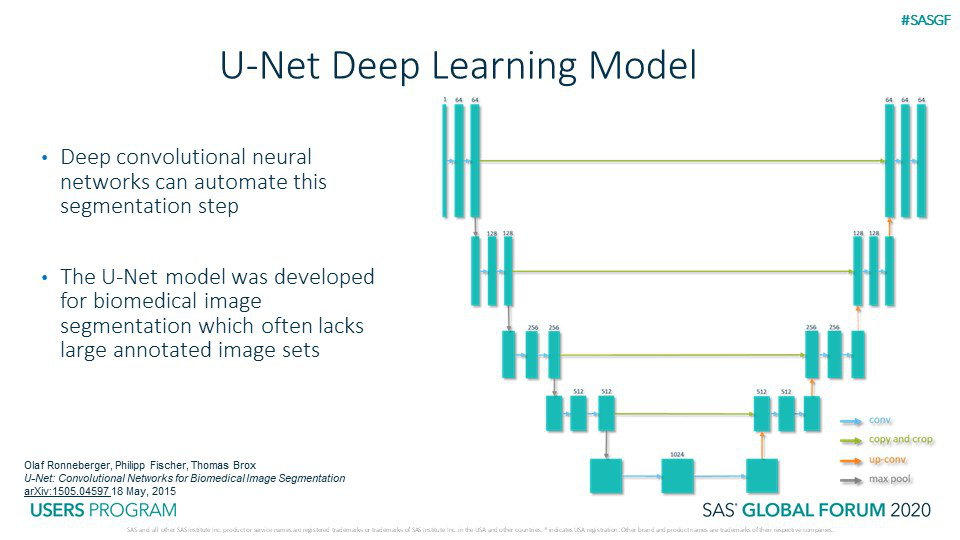

In [18]:
s.image.fetchImages(imageTable = 'slides').Images.Image[5]

### Create UNet Model

In [19]:
model = UNet(s, 
             n_classes=2,
             width=512,
             height=512,
             n_channels=1, 
             bn_after_convolutions=False)

NOTE: Model compiled successfully.


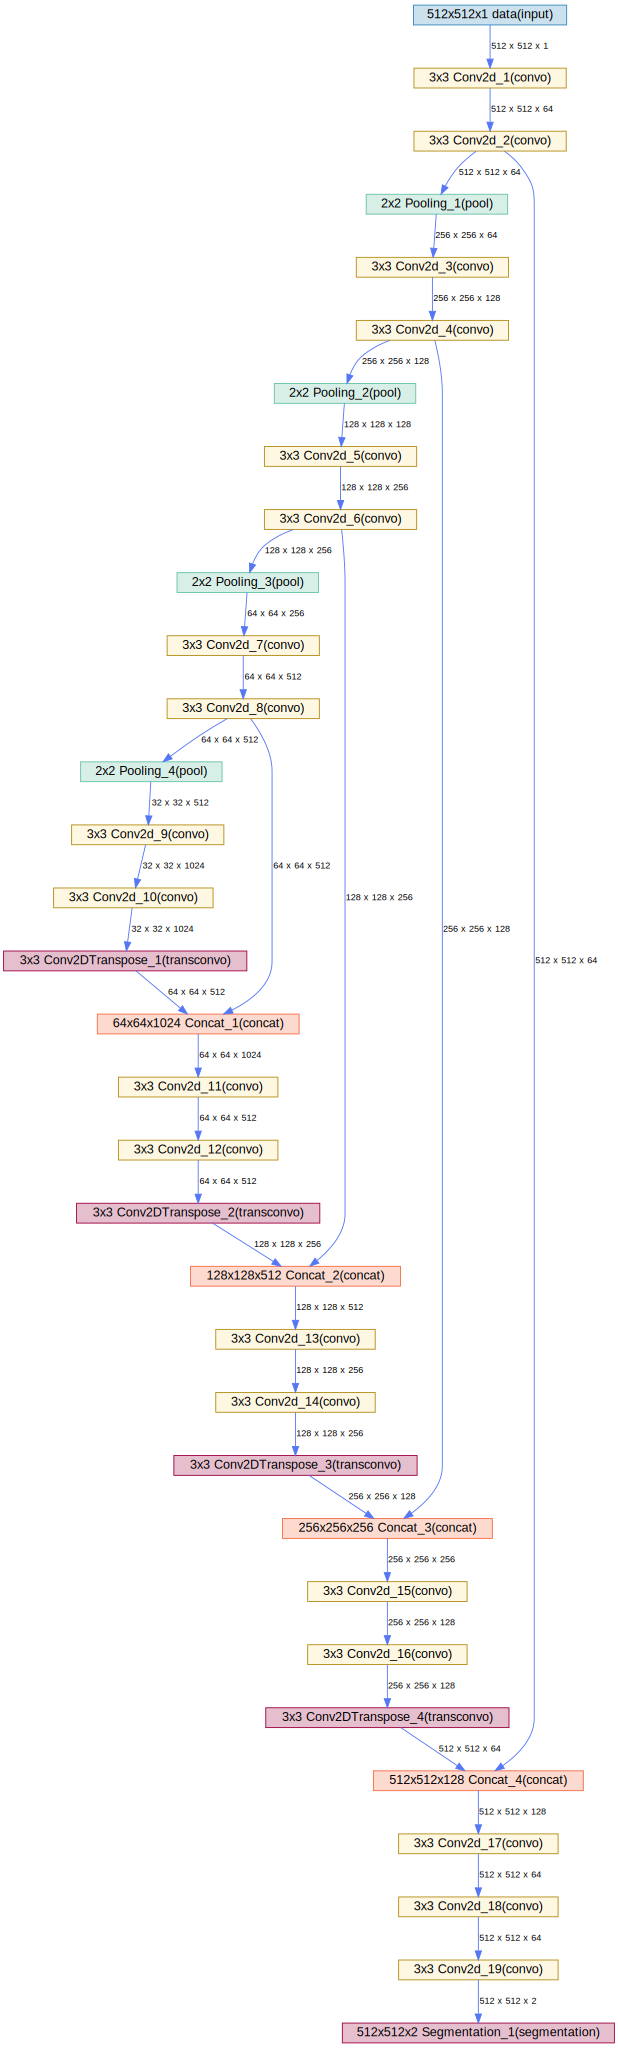

In [20]:
model.plot_network()

### Define training parameters

In [21]:
solver = AdamSolver(lr_scheduler=StepLR(learning_rate=0.0001, step_size=30, gamma=0.9), 
                    clip_grad_max = 100, 
                    clip_grad_min = -100)

optimizer = Optimizer(algorithm=solver, 
                      mini_batch_size=1, 
                      log_level=2, 
                      max_epochs=50, 
                      reg_l2=0.0001, 
                      seed=13309)

dataspecs=[dict(type='image', layer='data', data=['_image_']),
           dict(type='image', layer='Segmentation_1', data=['seg'])]

The following argument(s) learning_rate, learning_rate_policy, gamma, step_size, power are overwritten by the according arguments specified in lr_scheduler.


### Fit the model

In [22]:
model.fit(data=train,
          valid_table=validation,
          optimizer=optimizer, 
          data_specs=dataspecs, 
          n_threads=32, 
          record_seed=54321,
          force_equal_padding=True,
          save_best_weights=True, 
          gpu=dict(devices=[0,1])
          )

NOTE: Training from scratch.
NOTE: Using sysgpu01.unx.sas.com: 2 out of 4 available GPU devices.
NOTE:  Synchronous mode is enabled.
NOTE:  The total number of parameters is 34513282.
NOTE:  The approximate memory cost is 52318.00 MB.
NOTE:  Loading weights cost       0.00 (s).
NOTE:  Initializing each layer cost      23.80 (s).
NOTE:  The total number of threads on each worker is 32.
NOTE:  The total mini-batch size per thread on each worker is 1.
NOTE:  The maximum mini-batch size across all workers for the synchronous mode is 32.
NOTE:  Number of input variables:     1
NOTE:  Number of numeric input variables:      1
NOTE:  Epoch Learning Rate        Loss  Fit Error  Validation Loss Validation Error   Time(s)
NOTE:  0        0.0001       3.004e+04    0.01139             1411         0.000698    75.00
NOTE:  1        0.0001            1406   0.000751             1147         0.000698    53.85
NOTE:  2        0.0001            1237   0.000763              994         0.000698    53.84

[ModelInfo]

                                         Descr                         Value
 0   Model Name                                 unet                        
 1   Model Type                                 Convolutional Neural Network
 2   Number of Layers                                     33                
 3   Number of Input Layers                                1                
 4   Number of Output Layers                               0                
 5   Number of Convolutional Layers                       19                
 6   Number of Pooling Layers                              4                
 7   Number of Fully Connected Layers                      0                
 8   Number of Concatenation Layers                        4                
 9   Number of Transpose Convolution Layers                4                
 10  Number of Segmentation Layers                         1                
 11  Number of Weight Parameters                    34506432                
 12  Number of Bias Parameters                          6850                
 13  Total Number of Model Parameters               34513282                
 14  Approximate Memory Cost for Training (MB)         52383                

[OptIterHistory]

     Epoch  LearningRate          Loss  FitError    L2Norm    ValidLoss  \
 0   1      0.00010       30043.423679  0.011388  0.673892  1410.516592   
 1   2      0.00010       1405.655800   0.000751  0.659619  1147.467990   
 2   3      0.00010       1237.400571   0.000763  0.651844  993.963451    
 3   4      0.00010       1167.739603   0.000745  0.648050  878.914096    
 4   5      0.00010       940.270184    0.000761  0.646480  616.885535    
 5   6      0.00010       633.527666    0.000742  0.646287  453.525847    
 6   7      0.00010       457.549162    0.000757  0.646689  333.419496    
 7   8      0.00010       445.369965    0.000765  0.647080  315.035738    
 8   9      0.00010       411.410260    0.000755  0.647682  333.807903    
 9   10     0.00010       364.841303    0.000755  0.648492  264.790327    
 10  11     0.00010       344.517356    0.000758  0.649261  303.428245    
 11  12     0.00010       320.300198    0.000752  0.649981  259.231197    
 12  13     0.00010       273.979162    0.000762  0.650622  262.685916    
 13  14     0.00010       258.815844    0.000749  0.651114  241.064830    
 14  15     0.00010       241.017937    0.000467  0.651789  242.798061    
 15  16     0.00010       226.439632    0.000333  0.653148  188.800921    
 16  17     0.00010       205.952714    0.000314  0.654688  180.516394    
 17  18     0.00010       153.837159    0.000247  0.656058  189.213932    
 18  19     0.00010       158.489311    0.000241  0.657098  160.646386    
 19  20     0.00010       134.102727    0.000213  0.658161  143.147675    
 20  21     0.00010       120.114039    0.000192  0.658931  156.446126    
 21  22     0.00010       112.301341    0.000178  0.659536  129.415042    
 22  23     0.00010       114.272860    0.000179  0.660085  154.545107    
 23  24     0.00010       111.432736    0.000176  0.660733  138.023570    
 24  25     0.00010       103.210250    0.000166  0.661304  116.893545    
 25  26     0.00010       104.158239    0.000165  0.661757  125.504614    
 26  27     0.00010       95.020817     0.000153  0.662258  117.161270    
 27  28     0.00010       89.854172     0.000144  0.662636  118.161634    
 28  29     0.00010       85.444479     0.000138  0.662922  118.498866    
 29  30     0.00010       82.222410     0.000133  0.663222  107.894397    
 30  31     0.00009       76.658425     0.000124  0.663490  103.568373    
 31  32     0.00009       77.308087     0.000126  0.663717  106.918386    
 32  33     0.00009       75.176644     0.000122  0.663996  113.718948    
 33  34     0.00009       72.234499     0.000117  0.664190  112.015312    
 34  35     0.00009       68.702986     0.000112  0.664397  99.110842     
 35  36     0.00009       69.273405 

### Load weights

In [23]:
weights_path = 'path to weights and attributes'
model.load_weights(weights_path+'/UNet_weights.sashdat')

NOTE: Model weights attached successfully!
NOTE: UNet_weights_attr.sashdat is used as weigths attribute.
NOTE: Model attributes attached successfully!


### Predict segmentation for test set

In [24]:
model.predict(test, gpu=dict(devices=[0,1]))

NOTE: Using sysgpu01.unx.sas.com: 2 out of 4 available GPU devices.


[ScoreInfo]

                          Descr         Value
 0  Number of Observations Read           634
 1  Number of Observations Used           634
 2  Misclassification Error (%)      0.017236
 3  Pixel Accuracy (%)               99.97787
 4  Mean Accuracy (%)                98.29181
 5  Mean IoU (%)                     87.84488
 6  Frequency Weighted IoU (%)       99.78626
 7  Loss Error                       128.4363

[OutputCasTables]

             casLib              Name  Rows  Columns  \
 0  CASUSER(coambr)  Valid_Res_iPJz13  634   524300    
 
                                                  casTable  
 0  CASTable('Valid_Res_iPJz13', caslib='CASUSER(coambr)')  

+ Elapsed: 67.4s, user: 117s, sys: 25.1s, mem: 1.09e+05mb

### Condense images

In [25]:
img_size=512

def compile_segmentation_predictions():
    cvars = ['origimage', 'c0']
    for i in range(1, img_size*img_size):
        list.append(cvars, 'c' + str(i))

    cvarspgm = "length origimage varchar(*); origimage=_image_; c0=input(_DL_PredName0_, 12.); "
    for i in range(1, img_size*img_size):
        cvarspgm += 'c' + str(i) + '=input(_DL_PredName' + str(i) + '_, 12.); '

    s.table.view(
        name='oview',
        tables=[dict(name=model.valid_res_tbl.name,
                     computedvars=cvars, 
                     computedvarsprogram=cvarspgm,
                     varlist=['_DL_PredName0_','_bioMedId_','_label_','_sliceIndex_','_id_','_bioMedDimension_', 'seg'])],
        replace=True)
    s.image.condenseimages(table='oview',
                           width=img_size, height=img_size, 
                           casout=dict(name='final_images_predicted', replace=True),
                           numberofchannels=1,
                           depth='bit8',
                           copyvars=['_DL_PredName0_','_bioMedId_','_bioMedDimension_','_label_','_sliceIndex_', 'origimage','_id_','seg']),
    
compile_segmentation_predictions()

NOTE: 634 out of 634 images were processed successfully and saved to the Cloud Analytic Services table final_images_predicted.


### Annotate Images

In [26]:
s.fedsql.execdirect("create table annotated {options replace=true}"
                    "as (select * from final_images_predicted)")

s.table.altertable(table='annotated',
                   columns=[dict(name='_dimension_', rename='dim'),
                            dict(name='_resolution_', rename='res'),
                            dict(name='_imageformat_', rename='form')])

s.image.annotateimages(images=dict(table='annotated', image='origimage'),
                       annotations=[
                            dict(annotationparameters=
                                dict(annotationtype='segmentation',
                                    image='seg',
                                    colorMap='hsv',
                                    transparency=50,
                                    inputbackground=0
                                    )),
                           dict(annotationparameters=
                                dict(annotationtype='segmentation',
                                    image='_image_',
                                    dimension='dim',
                                    resolution='res',
                                    imageformat='form',
                                    colorMap='cool',
                                    transparency=50,
                                    inputbackground=0
                                    ))
                       ],
                       copyVars=['_sliceIndex_', '_label_'],
                       casout=dict(name='overlay', replace=True))

NOTE: Table ANNOTATED was created in caslib CASUSER(coambr) with 634 rows returned.
NOTE: 634 of 634 images were processed successfully and saved as encoded images to the Cloud Analytic Services table overlay.


[OutputCasTables]

             casLib     Name Label  Rows  Columns  \
 0  CASUSER(coambr)  overlay        634   4         
 
                                         casTable  
 0  CASTable('overlay', caslib='CASUSER(coambr)')  

+ Elapsed: 0.327s, user: 12.8s, sys: 2.18s, mem: 288mb

NOTE: Table OVERLAY contains compressed images.


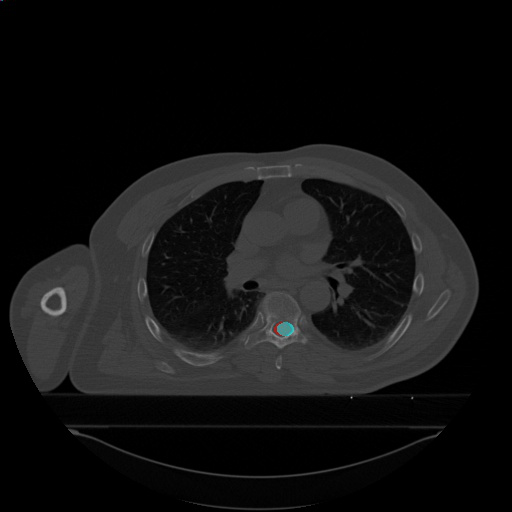

NOTE: Table OVERLAY contains compressed images.


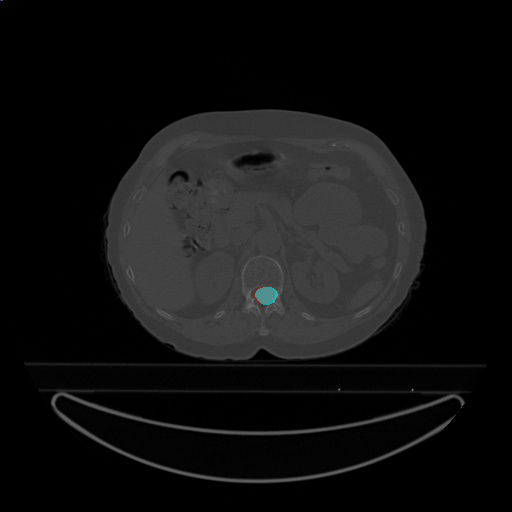

NOTE: Table OVERLAY contains compressed images.


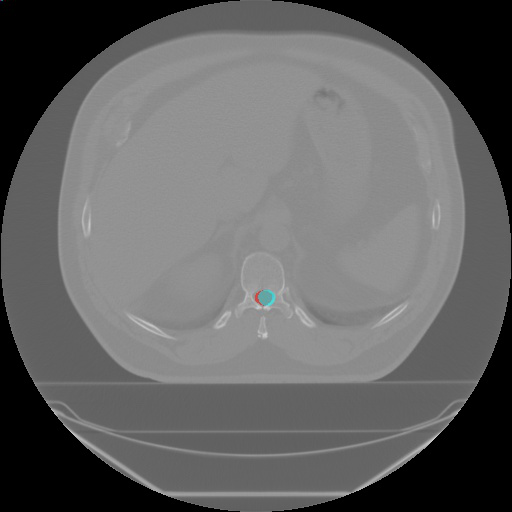

In [27]:
display(s.image.fetchimages(table='overlay', to=200).Images['Image'][15])
display(s.image.fetchimages(table='overlay', to=200).Images['Image'][20])
display(s.image.fetchimages(table='overlay', to=200).Images['Image'][25])

### Import images back into 3D

In [28]:
# Get decoded geometry info from CT scans
expname = 'LCTSC-Test-S3-204'
single_image_query = "_label_='"+expname+"'"
image_rows = s.CASTable('image').query(single_image_query).to_frame()

image_dims = image_rows["_dimension_"]
image_fmts = image_rows["_channelType_"]
image_images = image_rows["_image_"]
image_ress = image_rows["_resolution_"]
image_scas = image_rows["_spacing_"]
image_poss = image_rows["_position_"]
image_oris = image_rows["_orientation_"]
image_id = image_rows["_id_"]

# Import ground truth test set back into 3D
tmpTable=test.query("_label_ like 'LCTSC-Test-S3-204'")
ground_truth_seg = s.CASTable('ground_truth_seg', replace=True)
s.partition(table=tmpTable, casout=dict(name='ground_truth_seg', replace=True))

final_segs = s.CASTable('final_segs', replace=True)
s.biomedimage.processbiomedimages(
    images=dict(table=dict(name="ground_truth_seg"), image='seg'),
    steps=[dict(stepparameters=dict(steptype='import',targetDimension=3))],
    decode=True,
    copyVars=['_id_', '_label_'],
    casout=final_segs
)

final_testim = s.CASTable('final_testim', replace=True)
s.biomedimage.processbiomedimages(
    images=dict(table=dict(name="test")),
    steps=[dict(stepparameters=dict(steptype='import',targetDimension=3))],
    decode=True,
    copyVars=['_id_', '_label_'],
    casout=final_testim
)

# Import predicted images into 3D
import_images = s.CASTable('import_images', replace=True)
s.biomedimage.processbiomedimages(
    images=dict(table=dict(name="final_images_predicted")),
    steps=[dict(stepparameters=dict(steptype='import',targetDimension=3))],
    decode=True,
    copyVars=['_id_', '_label_'],
    casout=import_images
)

import_images_geo = s.CASTable('import_images_geo')
s.fedsql.execdirect("create table import_images_geo {options replace=true} as "
                        "select a.*, b._position_, b._orientation_, b._spacing_ "
                        "from import_images as a inner join image as b "
                        "on a._label_=b._label_")

tmpTable=import_images_geo.query("_label_ like 'LCTSC-Test-S3-204'")
single_import_image = s.CASTable('single_import_image', replace=True)
s.partition(table=tmpTable, casout=dict(name='single_import_image', replace=True))

NOTE: Processed 155 images from Cloud Analytic Services table GROUND_TRUTH_SEG.
NOTE: Processed 634 images from Cloud Analytic Services table TEST.
NOTE: Processed 634 images from Cloud Analytic Services table FINAL_IMAGES_PREDICTED.
NOTE: Table IMPORT_IMAGES_GEO was created in caslib CASUSER(coambr) with 17 rows returned.


[caslib]

 'CASUSER(coambr)'

[tableName]

 'SINGLE_IMPORT_IMAGE'

[rowsTransferred]

 0

[shuffleWaitTime]

 0.0

[minShuffleWaitTime]

 1e+300

[maxShuffleWaitTime]

 0.0

[averageShuffleWaitTime]

 0.0

[casTable]

 CASTable('SINGLE_IMPORT_IMAGE', caslib='CASUSER(coambr)')

+ Elapsed: 0.102s, user: 0.0311s, sys: 0.0853s, mem: 325mb

### Build surfaces for ground truth and predicted segmentations

In [29]:
# Build predicted image surface
verticesMasked = s.CASTable('verticesMasked', replace=True)
facesMasked = s.CASTable('facesMasked', replace=True)
s.biomedimage.buildsurface(images=dict(table=single_import_image),
                           thresholds=[dict(low=1, high=1000)],
                           smoothing=dict(iterations=3),
                           outputvertices=verticesMasked,
                           outputfaces=facesMasked
                          )

fetchedVertices=verticesMasked.to_frame()
fetchedFaces=facesMasked.to_frame()

x = fetchedVertices.loc[:, ["_x_"]]
y = fetchedVertices.loc[:, ["_y_"]]
z = fetchedVertices.loc[:, ["_z_"]]
flist = fetchedFaces.loc[:, ["_v1_", "_v2_", "_v3_"]]

rgb = (255, 0, 0)
op = 0.75

# Build ground truth image surface
final_segs_geo = s.CASTable('final_segs_geo')

s.fedsql.execdirect("create table final_segs_geo {options replace=true} as "
                        "select a.*, b._position_, b._orientation_, b._spacing_ "
                        "from final_segs as a inner join image as b "
                        "on a._label_=b._label_")

vertices_seg = s.CASTable('vertices_seg', replace=True)
faces_seg = s.CASTable('faces_seg', replace=True)
s.biomedimage.buildsurface(images=dict(table=final_segs_geo),
                           thresholds=[dict(low=1, high=1000)],
                           smoothing=dict(iterations=3),
                           outputvertices=vertices_seg,
                           outputfaces=faces_seg)

fetchedVertices=vertices_seg.to_frame()
fetchedFaces=faces_seg.to_frame()

xs = fetchedVertices.loc[:, ["_x_"]]
ys= fetchedVertices.loc[:, ["_y_"]]
zs = fetchedVertices.loc[:, ["_z_"]]
flists = fetchedFaces.loc[:, ["_v1_", "_v2_", "_v3_"]]

rgbs = (0, 255, 0)
ops = 0.75

NOTE: Processed 1 image from Cloud Analytic Services table SINGLE_IMPORT_IMAGE.
NOTE: Table FINAL_SEGS_GEO was created in caslib CASUSER(coambr) with 1 rows returned.
NOTE: Processed 1 image from Cloud Analytic Services table FINAL_SEGS_GEO.


NOTE: Table SLIDES contains decompressed images.


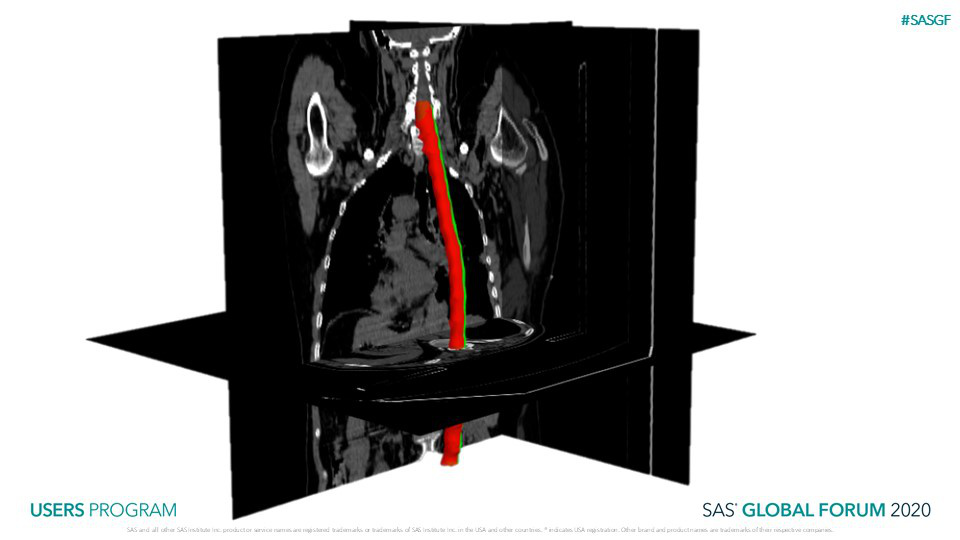

In [30]:
s.image.fetchImages(imageTable = 'slides').Images.Image[6]

### Display spinal cord segmentation results in 3D

In [31]:
mlab.triangular_mesh(xs, ys, zs, flists, color=tuple([c/255 for c in rgbs]),opacity=ops)
mlab.triangular_mesh(x, y, z, flist, color=tuple([c/255 for c in rgb]),opacity=op)
display_slice_3d(image_images, image_dims, image_ress, image_fmts, image_poss,image_oris,image_scas,(0, 1, 2),0,55,0)
display_slice_3d(image_images, image_dims, image_ress, image_fmts, image_poss,image_oris,image_scas,(2, 1, 0),0,120,0)
display_slice_3d(image_images, image_dims, image_ress, image_fmts, image_poss,image_oris,image_scas,(1, 0, 2),0,250,0)
mlab.show()

NOTE: Table SLIDES contains decompressed images.


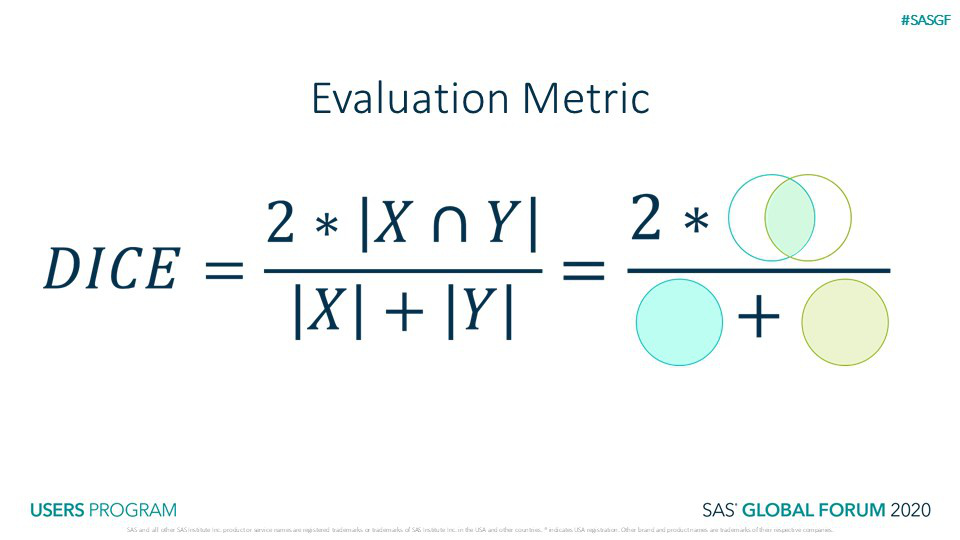

In [32]:
s.image.fetchImages(imageTable = 'slides').Images.Image[7]

### Compute DICE score

In [33]:
num_test_slice=test.shape[0]

images=s.image.fetchimages(table='test',
                           to = num_test_slice,
                           image='seg',
                           sortBy=[dict(name='_label_', order='ascending'),
                                   dict(name='_sliceIndex_', order='ascending')],
                           fetchVars=['_label_','pid','_sliceIndex_','seg'])

images2=s.image.fetchimages(table='final_images_predicted',
                            to = num_test_slice,
                            image="_image_",
                           sortBy=[dict(name='_label_', order='ascending'),
                                   dict(name='_sliceIndex_', order='ascending')],
                            fetchVars=['_label_','pid','_sliceIndex_','seg'])

num=0
den=0

for n in range(0, num_test_slice):
    
    # Compute Dice coefficient
    im1=images['Images']['Image'][n]
    im2=images2['Images']['Image'][n]
            
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    intersection = np.logical_and(im1, im2)
    
    num = num + 2. * intersection.sum()
    den = den + im1.sum() + im2.sum()

num/den

NOTE: Table TEST contains compressed images.
NOTE: Table FINAL_IMAGES_PREDICTED contains decompressed images.


0.7128660886488454

### Use segmentation image to mask CT scan

NOTE: Table SLIDES contains decompressed images.


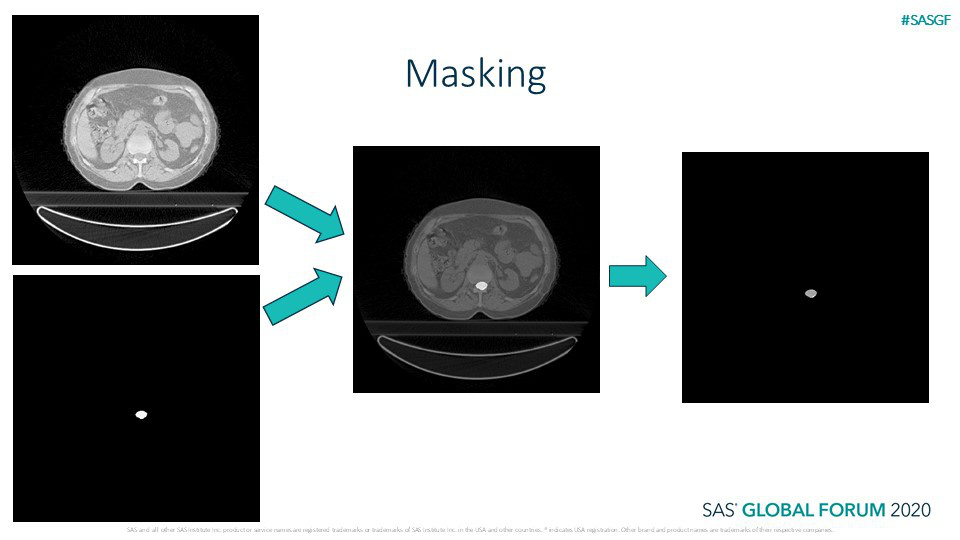

In [34]:
s.image.fetchImages(imageTable = 'slides').Images.Image[8]

In [35]:
s.fedsql.execdirect("create table q_test {options replace=true} as "
                        "select * from import_images_geo")

s.table.altertable(table='q_test',
                   columns=[dict(name='_dimension_', rename='dim'),
                            dict(name='_resolution_', rename='res'),
                            dict(name='_imageformat_', rename='form'),
                            dict(name='_orientation_', rename='ori'),
                            dict(name='_position_', rename='pos'),
                            dict(name='_spacing_', rename='spa'),
                            dict(name='_image_', rename='seg')])

jdata = s.CASTable('jdata')

s.fedsql.execdirect("create table jdata {options replace=true} as "
                        "select a.*, b._image_ "
                        "from q_test as a inner join final_testim as b "
                        "on a._label_=b._label_ ")

bdata = s.CASTable('bdata', replace=True)

s.biomedimage.processbiomedimages(
    images=dict(
        table=jdata, dimension='dim', resolution='res', imageformat='form'),
    steps=[dict(stepparameters=dict(
                steptype='binary_operation',
                binaryoperation=dict(
                    binaryoperationtype='mask_specific',
                    image='seg',
                    dimension='dim', 
                    resolution='res', 
                    imageformat='form',
                    outputBackground=-1000
                )))],
    casout=bdata,
    decode=True,
    addcolumns=['channeltype', 'position', 'orientation', 'spacing', 'width', 'height', 'depth'],
    copyVars=['_id_', '_label_'],
)

NOTE: Table Q_TEST was created in caslib CASUSER(coambr) with 17 rows returned.
NOTE: Table JDATA was created in caslib CASUSER(coambr) with 17 rows returned.
NOTE: Processed 17 images from Cloud Analytic Services table JDATA.


[OutputCasTables]

             casLib   Name Label  Rows  Columns  \
 0  CASUSER(coambr)  bdata        17    14        
 
                                       casTable  
 0  CASTable('bdata', caslib='CASUSER(coambr)')  

+ Elapsed: 0.886s, user: 3s, sys: 0.459s, mem: 409mb

### Quantify data

In [36]:
vol = s.CASTable(name='vol', replace=True)

s.biomedimage.quantifybiomedimages(images=dict(table='bdata'),
                                   quantities=[dict(quantityparameters=dict(quantitytype='content',usespacing=True)),
                                               dict(quantityparameters=dict(quantitytype='mean')),
                                               dict(quantityparameters=dict(quantitytype='maximum')),
                                               dict(quantityparameters=dict(quantitytype='minimum'))],
                                   inputbackground=0,
                                   labelParameters=dict(labelType='basic', connectivity='vertex'),
                                   region='image',
                                   copyvars=['_id_', '_label_'],
                                   casout=vol)
vol.to_frame()

NOTE: Processed 17 images from Cloud Analytic Services table BDATA.


Selected Rows from Table VOL

    _imageId_  _content_    _mean_  _maximum_  _minimum_  _id_  \
0   1116       11749.0    0.183264  231.0      0.0        1116   
1   683        6436.0     0.065477  138.0      0.0        683    
2   7834       4911.0     0.024017  176.0      0.0        7834   
3   954        7638.0     0.071217  176.0      0.0        954    
4   7835       6133.0     0.050966  121.0      0.0        7835   
5   2370       520.0      0.045151  109.0      0.0        2370   
6   1575       2730.0     0.021362  34.0       0.0        1575   
7   1718       6784.0     0.150630  237.0      0.0        1718   
8   2576       33439.0    0.055379  248.0      0.0        2576   
9   8185       584.0      0.031531  111.0      0.0        8185   
10  955        12027.0    0.126630  175.0      0.0        955    
11  433        19749.0    0.059247  156.0      0.0        433    
12  7399       7419.0     0.081494  146.0      0.0        7399   
13  2055       963.0      0.044730  103.0      0.0        2055   
14  1438       4576.0     0.104053  197.0      0.0        1438   
15  1293       6906.0     0.134973  203.0      0.0        1293   
16  565        8973.0     0.064918  134.0      0.0        565    

              _label_  
0   LCTSC-Test-S2-102  
1   LCTSC-Test-S1-201  
2   LCTSC-Test-S3-103  
3   LCTSC-Test-S1-204  
4   LCTSC-Test-S3-104  
5   LCTSC-Test-S3-203  
6   LCTSC-Test-S2-202  
7   LCTSC-Test-S2-203  
8   LCTSC-Test-S3-204  
9   LCTSC-Test-S3-201  
10  LCTSC-Test-S2-101  
11  LCTSC-Test-S1-103  
12  LCTSC-Test-S1-203  
13  LCTSC-Test-S3-102  
14  LCTSC-Test-S2-201  
15  LCTSC-Test-S2-104  
16  LCTSC-Test-S1-104

### Import ground truth, mask and quantify 

In [37]:
test_import = s.CASTable('test_import', replace=True)
s.biomedimage.processbiomedimages(
    images=dict(table=dict(name="test"), image='seg'),
    steps=[dict(stepparameters=dict(steptype='import',targetDimension=3))],
    decode=True,
    copyVars=['_id_', '_label_'],
    addColumns=['width', 'height', 'depth', 'channeltype', 'spacing', 'position', 'orientation'],
    casout=test_import
)

s.fedsql.execdirect("create table q_test_gt {options replace=true} as "
                        "select * from test_import")

s.table.altertable(table='q_test_gt',
                   columns=[dict(name='_dimension_', rename='dim'),
                            dict(name='_resolution_', rename='res'),
                            dict(name='_imageformat_', rename='form'),
                            dict(name='_orientation_', rename='ori'),
                            dict(name='_position_', rename='pos'),
                            dict(name='_spacing_', rename='spa'),
                            dict(name='_image_', rename='seg')])

jdata_gt = s.CASTable('jdata_gt')

s.fedsql.execdirect("create table jdata_gt {options replace=true} as "
                        "select a.*, b._image_ "
                        "from q_test_gt as a inner join final_testim as b "
                        "on a._label_=b._label_ ")

bdata_gt = s.CASTable('bdata_gt', replace=True)

s.biomedimage.processbiomedimages(
    images=dict(
        table=jdata_gt, dimension='dim', resolution='res', imageformat='form'),
    steps=[dict(stepparameters=dict(
                steptype='binary_operation',
                binaryoperation=dict(
                    binaryoperationtype='mask_specific',
                    image='seg',
                    dimension='dim', 
                    resolution='res', 
                    imageformat='form',
                    outputBackground=-1000
                )))],
    casout=bdata_gt,
    decode=True,
    addcolumns=['position', 'orientation', 'spacing', 'channeltype', 'width', 'height', 'depth'],
    copyVars=['_id_', '_label_'],
)

vol_orig = s.CASTable(name='vol_orig', replace=True)

s.biomedimage.quantifyBioMedImages(
    images=dict(table='bdata_gt'),
    region='image',
    quantities=[dict(quantityparameters=dict(quantitytype='CONTENT',usespacing=True)),
                dict(quantityparameters=dict(quantitytype='MEAN')),
                dict(quantityparameters=dict(quantitytype='MAXIMUM')),
                dict(quantityparameters=dict(quantitytype='MINIMUM')),
    ],
    inputbackground=0,
    labelParameters=dict(labelType='basic', connectivity='vertex'),
    copyvars=['_label_', '_id_'],
    casout=vol_orig)

NOTE: Processed 634 images from Cloud Analytic Services table TEST.
NOTE: Table Q_TEST_GT was created in caslib CASUSER(coambr) with 17 rows returned.
NOTE: Table JDATA_GT was created in caslib CASUSER(coambr) with 17 rows returned.
NOTE: Processed 17 images from Cloud Analytic Services table JDATA_GT.
NOTE: Processed 17 images from Cloud Analytic Services table BDATA_GT.


[OutputCasTables]

             casLib      Name Label  Rows  Columns  \
 0  CASUSER(coambr)  vol_orig        17    7         
 
                                          casTable  
 0  CASTable('vol_orig', caslib='CASUSER(coambr)')  

+ Elapsed: 0.239s, user: 1.08s, sys: 0.00312s, mem: 168mb

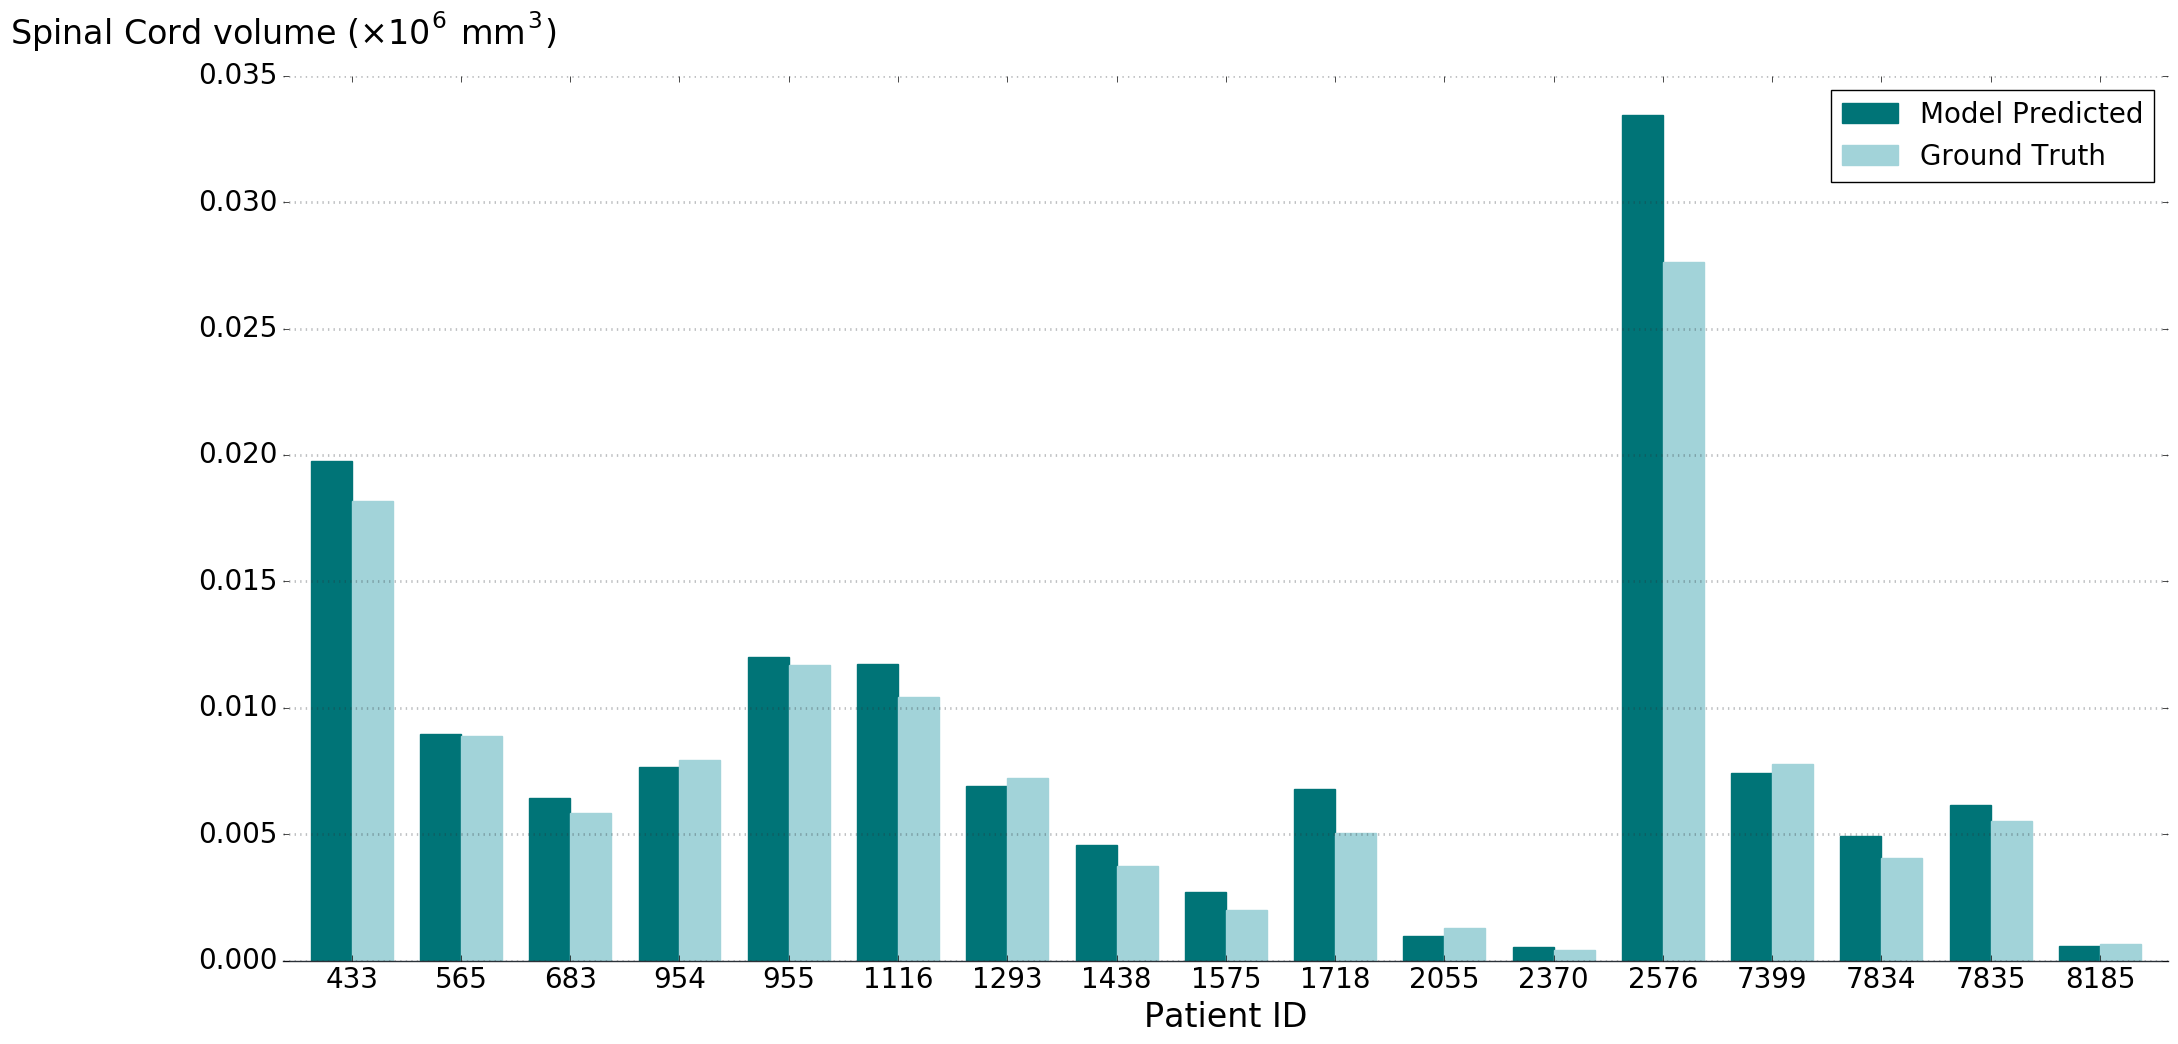

In [38]:
plot_volumes_with_ground_truth_sc(vol, vol_orig)

NOTE: Table SLIDES contains decompressed images.


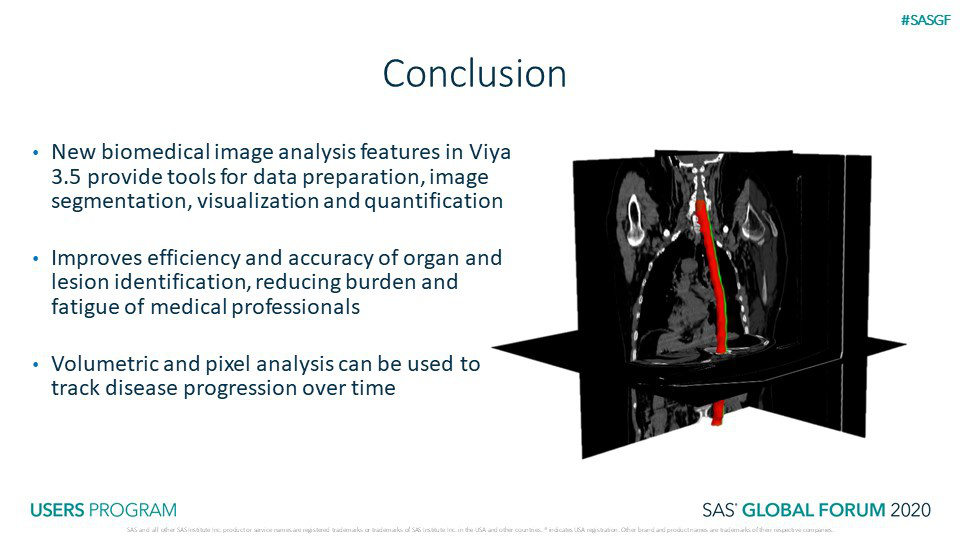

In [39]:
s.image.fetchImages(imageTable = 'slides').Images.Image[10]